# Correlation with clinical outcome

As described by Palma et al., we evaluated whether the merged model could be used to infer clinical outcomes of patients with specific mutations. Mutation profiles of the patients are identified as the combination of three important AML genes: FLT3, NPM1 and DNMT3A. BeatAML data is used in this analysis for the blast percentage patient data.

In [1]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

# model1name = "Bonzanni2013"
# model2name = "Krumsiek2011"

# BeatAML
805 patients (942 specimens) in total. 
> For DNA sequencing, we used the 11.9 megabase custom capture library that was developed to provide coverage of all variants previously reported in AML (including all variants that were detected from exome sequencing in our prior study).

# Clinical Outcome
## Data
Mutation, clinical data and drug response data are downloaded from the [BeatAML2 website](https://biodev.github.io/BeatAML2/):
1. [WES/targeted Sequencing Mutation Calls](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt)
2. [Clinical Summary](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx)
3. [Inhibitor AUC values](https://github.com/biodev/beataml2.0_data/raw/main/beataml_probit_curve_fits_v4_dbgap.txt)
4. [Inhibitor Families](https://github.com/biodev/beataml2.0_data/raw/main/beataml_drug_families.xlsx)

## Methods
Similar to the Palma approach

In [2]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations, chain  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
import xml.etree.ElementTree as ET # for parse the SBML file
import seaborn as sns # for plotting
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy import stats
from matplotlib.gridspec import GridSpec

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [3]:
model1 = biolqm.load("./Models/" + model1name + ".sbml")
model2 = biolqm.load("./Models/" + model2name + ".sbml")
merged_and = biolqm.load("./Models/merged_and_" + model1name + "_" + model2name + ".sbml")
merged_inhibitor_wins = biolqm.load("./Models/merged_inhibitor_wins_" + model1name + "_" + model2name + ".sbml")
merged_or = biolqm.load("./Models/merged_or_" + model1name + "_" + model2name + ".sbml")

In [4]:
# Get genes in each model
def getnodes(model_name):
    # Load and parse the SBML file
    tree = ET.parse("./Models/" + model_name + ".sbml")
    root = tree.getroot()
    
    # Define the namespace for SBML Level 3 Version 1 Core and Qual
    ns = {
        'sbml': 'http://www.sbml.org/sbml/level3/version1/core',
        'qual': 'http://www.sbml.org/sbml/level3/version1/qual/version1'
    }
    
    # Find all qualitativeSpecies in the model
    qual_species_list = root.findall('.//qual:qualitativeSpecies', ns)
    
    # Extract the IDs of the qualitativeSpecies
    qual_species_ids = []
    for species in qual_species_list:
        species_id = species.attrib.get('{http://www.sbml.org/sbml/level3/version1/qual/version1}id')
        if species_id:
            qual_species_ids.append(species_id)

    print(qual_species_ids)
    return qual_species_ids
    
gene_model1 = getnodes(model1name)
gene_model2 = getnodes(model2name)
gene_merged = list(set(gene_model1 + gene_model2))

['AKT1', 'CDKN2A', 'BCL2', 'CCND1', 'CEBPA', 'DNMT3A', 'MAPK1', 'ETV6', 'FBXW7', 'FLT3', 'GSK3B', 'HOXA9', 'MEIS1', 'MYC', 'NPM1', 'SOX4', 'STAT5A', 'TP53']
['External_quiescence', 'External_cycling', 'PIK3CA', 'TSC1', 'MTOR', 'FOXO3', 'ATM', 'ROS1', 'Mitochondria', 'Autophagy', 'ERAS', 'ETS1', 'MEFV', 'GSK3B', 'CTNNB1', 'MYC', 'BMI1', 'MDM2', 'TP53', 'CDKN1C', 'CDKN1A', 'CDKN1B', 'GFI1', 'RB1', 'E2F1', 'CCND1', 'CCNE1', 'S_phase', 'AKT1', 'CDKN2D', 'CDKN2A', 'Pro_apoptotic_proteins', 'Anti_apoptotic_proteins', 'CYCS', 'Apoptosis', 'Senescence']


In [5]:
# Function to determine mutation combination
def determine_combination(row):
    genes = row['symbol']
    has_flt3 = 'FLT3' in genes
    has_npm1 = 'NPM1' in genes
    has_dnmt3a = 'DNMT3A' in genes

    if has_flt3 and has_npm1 and has_dnmt3a:
        return "flt3_npm1_dnmt3a"
    elif has_flt3 and has_dnmt3a:
        return "flt3_dnmt3a"
    elif has_flt3 and has_npm1:
        return "flt3_npm1"
    elif has_npm1 and has_dnmt3a:
        return "npm1_dnmt3a"
    elif has_flt3:
        return "flt3"
    elif has_npm1:
        return "npm1"
    elif has_dnmt3a:
        return "dnmt3a"
    else:
        return "wt"

In [6]:
mutations = pd.read_csv("./Data/BeatAML/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("./Data/BeatAML/beataml_wv1to4_clinical.xlsx")
clinical = clinical[
    (clinical['dxAtSpecimenAcquisition'] == 'ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PRECURSOR NEOPLASMS') |
    (clinical['dxAtSpecimenAcquisition'] == 'ACUTE LEUKAEMIAS OF AMBIGUOUS LINEAGE')
]
clinical_df = pd.merge(mutations, clinical[['dbgap_subject_id', 'dbgap_dnaseq_sample','FLT3-ITD','NPM1']], left_on='dbgap_sample_id', right_on='dbgap_dnaseq_sample')

# Add FLT3-ITD
flt3_positive_df = clinical_df[clinical_df['FLT3-ITD'] == 'positive'].copy()
flt3_positive_df['symbol'] = 'FLT3'

# Add NPM1
npm1_positive_df = clinical_df[clinical_df['NPM1'] == 'positive'].copy()
npm1_positive_df['symbol'] = 'NPM1'

result_df = pd.concat([clinical_df, flt3_positive_df, npm1_positive_df], ignore_index=True)

In [7]:
grouped = result_df.groupby('dbgap_subject_id').agg(list).reset_index()
grouped['mutation'] = grouped.apply(determine_combination, axis=1)

# Merge the gene information with the clinical data
clinical_result = pd.merge(clinical, grouped[['dbgap_subject_id', 'mutation']], on='dbgap_subject_id')
clinical_result['survivalYears'] = clinical_result['ageAtDiagnosis'] + clinical_result['overallSurvival']/365
clinical_result = clinical_result[['dbgap_subject_id', 'mutation', '%.Blasts.in.BM', '%.Blasts.in.PB', 'survivalYears']]

# convert to numeric
clinical_result['%.Blasts.in.BM'] = pd.to_numeric(clinical_result['%.Blasts.in.BM'], errors='coerce')
clinical_result['%.Blasts.in.PB'] = pd.to_numeric(clinical_result['%.Blasts.in.PB'], errors='coerce')

# aggregate the mean PB of each mutation profile
clinical_aggr = clinical_result.pivot_table(
    index='mutation', 
    values=['%.Blasts.in.BM','%.Blasts.in.PB','survivalYears'],
    aggfunc='mean'
)
clinical_aggr.columns = ['BM_BLAST', 'PB_BLAST','Survival']
clinical_aggr.to_csv('./Data/BeatAML/clinical.csv')
clinical_aggr

,BM_BLAST,PB_BLAST,Survival
mutation,,,
dnmt3a,41.224590,44.661111,65.143983
flt3,69.519277,55.226923,57.285853
flt3_dnmt3a,64.387500,53.947368,63.542564
flt3_npm1,81.525862,69.364151,59.126350
flt3_npm1_dnmt3a,67.064286,58.534091,58.851408
npm1,64.609756,54.592000,58.598427
npm1_dnmt3a,58.327586,31.810000,60.901723
wt,52.732919,39.472314,58.280578


In [13]:
def simulation(model):
    
    # set the fix value for the simulations
    wt = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1")
    flt3 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1")
    npm1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0")
    dnmt3a = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1")
    npm1_dnmt3a = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0")
    flt3_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1")
    flt3_npm1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0")
    flt3_npm1_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0")

    # get the stable states
    networks = [wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a]
    results = pd.DataFrame()
    for network in networks:
        fps = biolqm.fixpoints(network)
        # take average if multiple stable states exist
        results = pd.concat([results, pd.DataFrame(fps).mean().to_frame().T],ignore_index=True)
    results.index = ["wt","flt3","npm1","dnmt3a","npm1_dnmt3a","flt3_dnmt3a","flt3_npm1","flt3_npm1_dnmt3a"]
    
    # calculate the phenotype scores
    results['APOPTOSIS'] = results['TP53'] - results['BCL2']
    results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
    results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
    
    # calculate the network scores
    results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
    simulation_results = results.T.sort_index()
    return simulation_results

def clinical_plot(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    
    # Plotting scatterplots
    clinicals = ['PB_BLAST', 'BM_BLAST']
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, clinical in enumerate(clinicals):
        ax = axes[i]
        # Extract network scores and clinical outcome values
        x = clinical_results.loc['NETWORK', :]
        y = clinical_results.loc[clinical, :]
        
        # Calculate Pearson Correlation and p-value
        pc, p_value = pearsonr(x, y)
    
        # Linear regression (best-fit line)
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
        
        # Create scatterplot
        ax.scatter(x, y)
        ax.set_title(f'{clinical} vs Network score')
        ax.set_xlabel('Network score')
        ax.set_ylabel('%' + clinical)
    
            # Annotate each data point
        for j in range(len(x)):
            label = x.index[j]
            ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
        
        # Annotate Pearson Correlation and p-value
        ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                transform=ax.transAxes, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()

def clinical_plot_bm(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    
    # Plotting scatterplots
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Extract network scores and clinical outcome values
    x = clinical_results.loc['NETWORK', :]
    y = clinical_results.loc['BM_BLAST', :]
    
    # Calculate Pearson Correlation and p-value
    pc, p_value = pearsonr(x, y)

    # Linear regression (best-fit line)
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
    
    # Create scatterplot
    ax.scatter(x, y)
    ax.set_title('Blast percentage vs Network score')
    ax.set_xlabel('Network score')
    ax.set_ylabel('Blast percentage')

    # Annotate each data point
    for j in range(len(x)):
        label = x.index[j]
        ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')

    
    # Annotate Pearson Correlation and p-value
    ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
            transform=ax.transAxes, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()

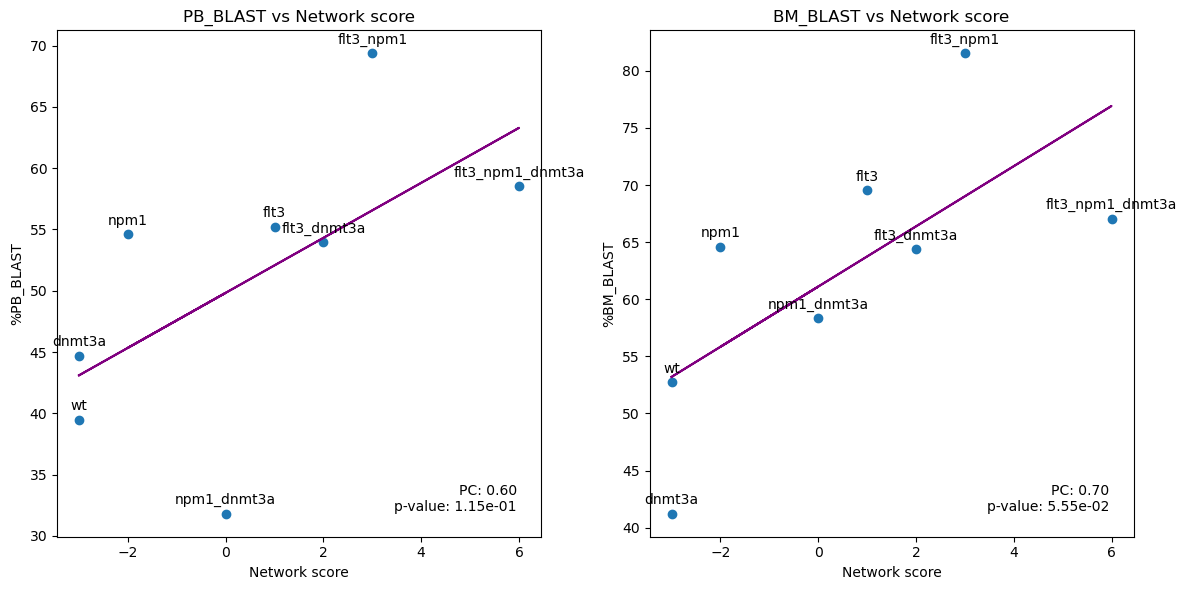

In [14]:
# The Palma results
simulation_results_1 = simulation(model1)
clinical_plot(simulation_results_1, './Data/BeatAML/clinical.csv')

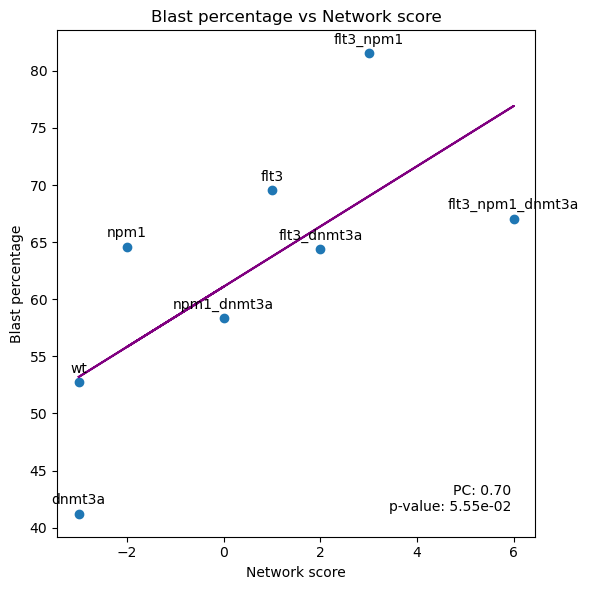

In [16]:
clinical_plot_bm(simulation_results_1, './Data/BeatAML/clinical.csv')

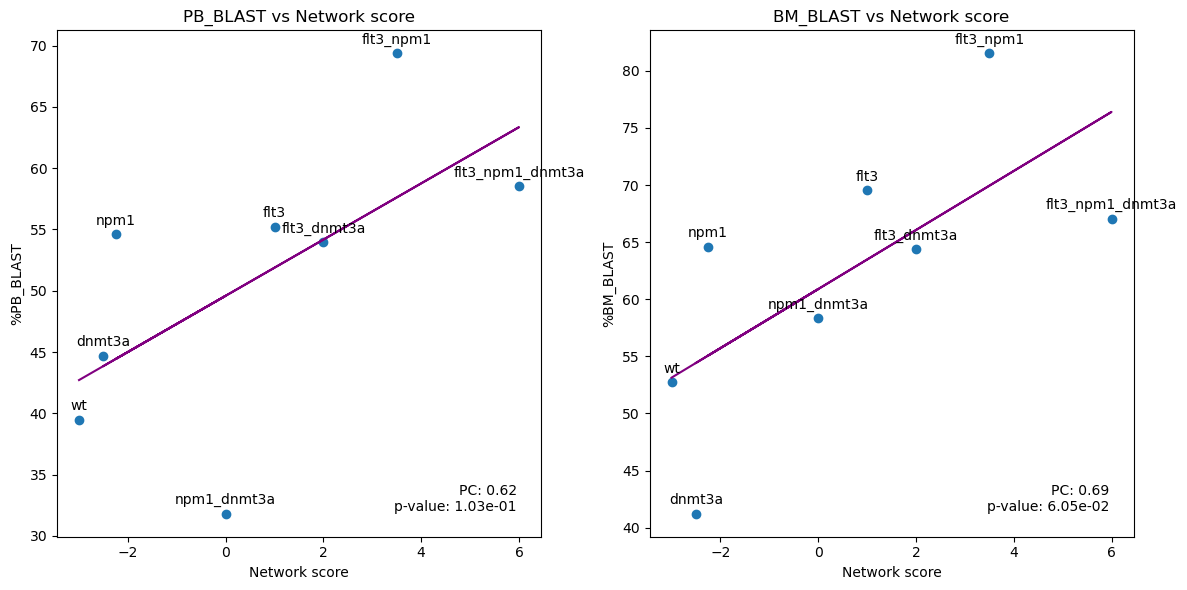

In [17]:
simulation_results_or = simulation(merged_or)
clinical_plot(simulation_results_or, './Data/BeatAML/clinical.csv')

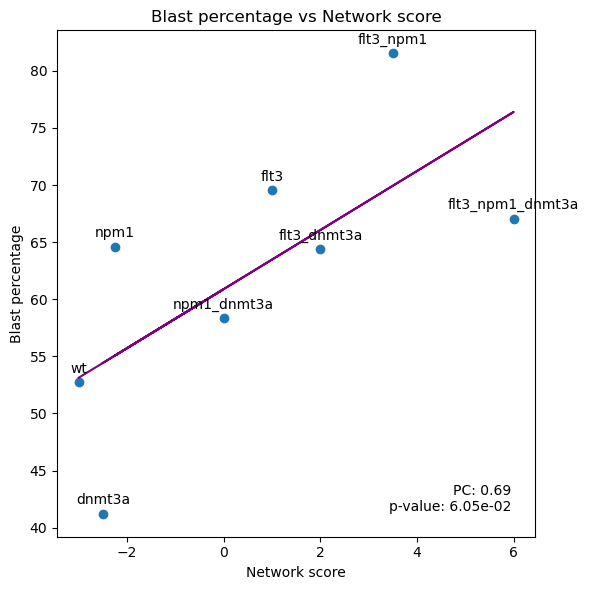

In [21]:
clinical_plot_bm(simulation_results_or, './Data/BeatAML/clinical.csv')

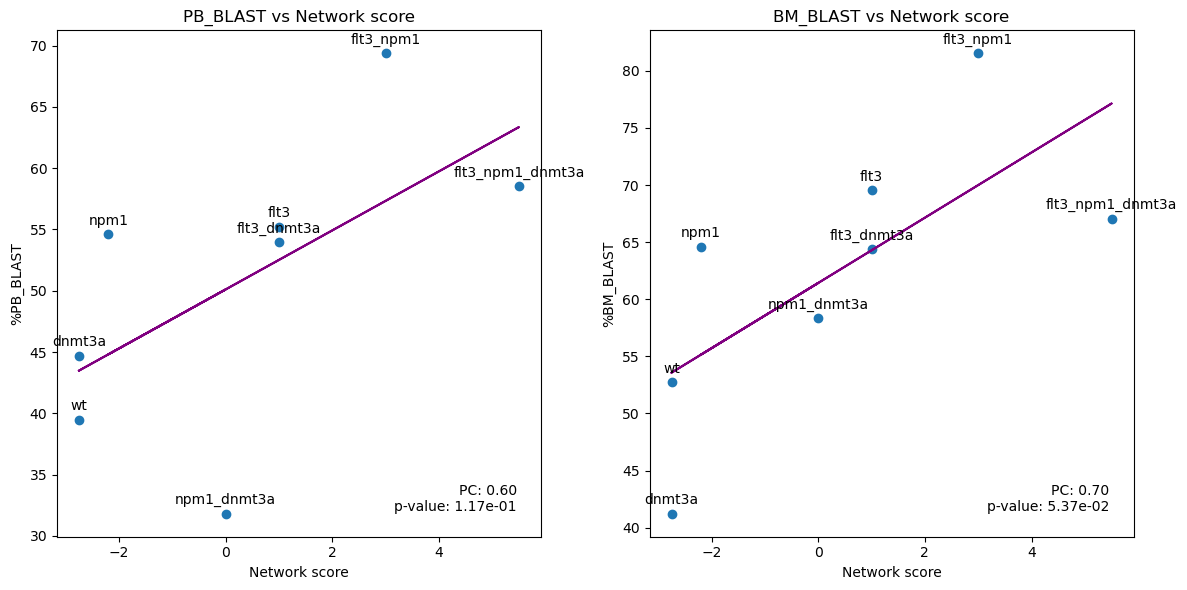

In [18]:
simulation_results_inhibitor_wins = simulation(merged_inhibitor_wins)
clinical_plot(simulation_results_inhibitor_wins, './Data/BeatAML/clinical.csv')

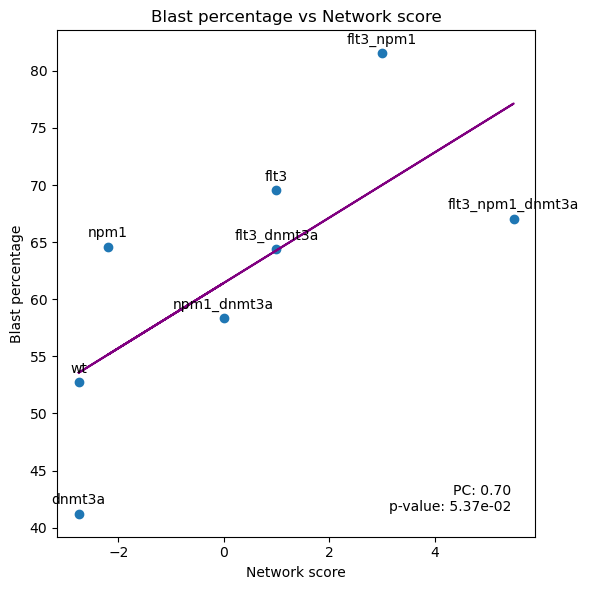

In [22]:
clinical_plot_bm(simulation_results_inhibitor_wins, './Data/BeatAML/clinical.csv')

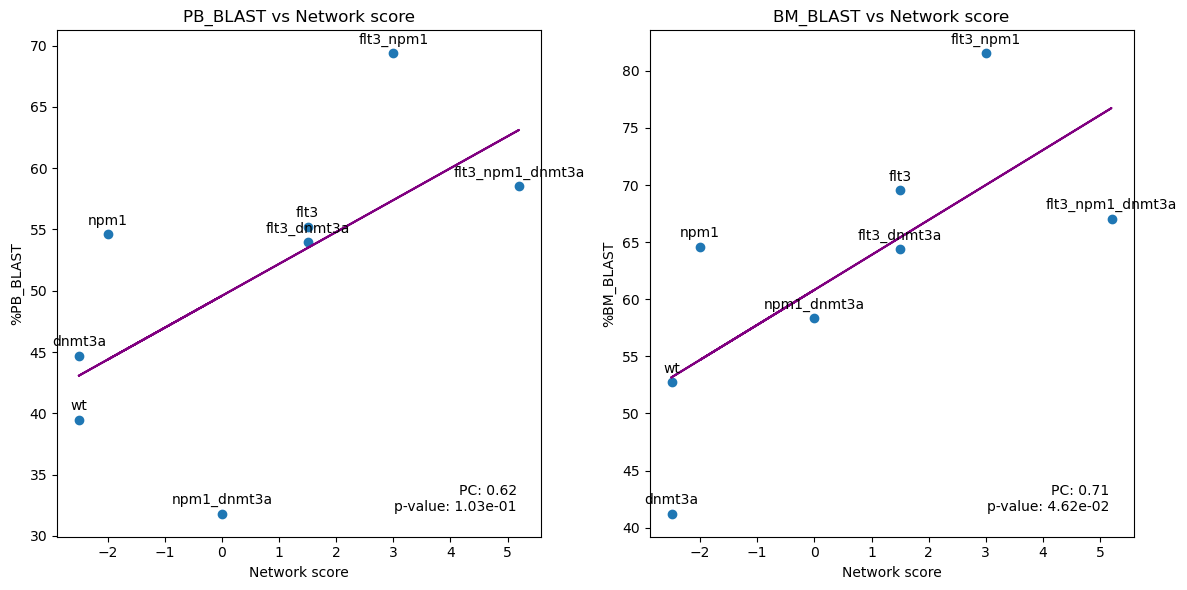

In [19]:
simulation_results_and = simulation(merged_and)
clinical_plot(simulation_results_and, './Data/BeatAML/clinical.csv')

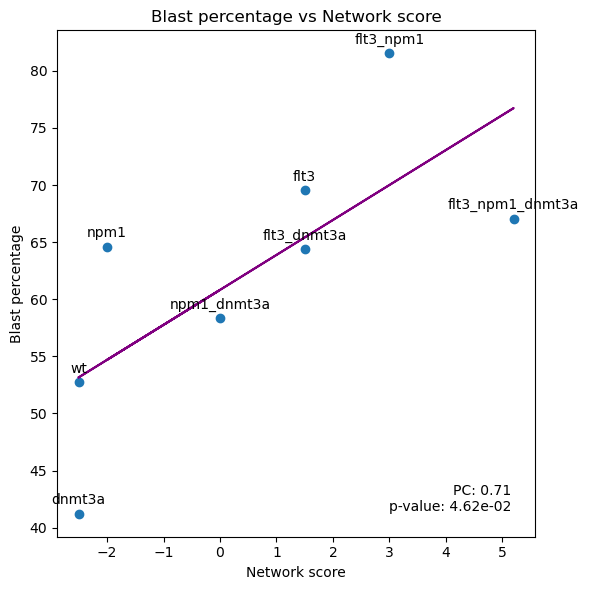

In [20]:
clinical_plot_bm(simulation_results_and, './Data/BeatAML/clinical.csv')

## Apply filters on SIFT and Polyphen

In [116]:
mutations = pd.read_csv("./Data/BeatAML/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("./Data/BeatAML/beataml_wv1to4_clinical.xlsx")
clinical_df = pd.merge(mutations, clinical[['dbgap_subject_id', 'dbgap_dnaseq_sample','FLT3-ITD','NPM1']], left_on='dbgap_sample_id', right_on='dbgap_dnaseq_sample')

mutations_df = clinical_df[
        # Apply 'sift' and 'polyphen' filters 
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging')))
    )
]

# Add FLT3-ITD
flt3_positive_df = clinical_df[clinical_df['FLT3-ITD'] == 'positive'].copy()
flt3_positive_df['symbol'] = 'FLT3'

result_df = pd.concat([mutations_df, flt3_positive_df], ignore_index=True)

grouped = result_df.groupby('dbgap_subject_id').agg(list).reset_index()
grouped['mutation'] = grouped.apply(determine_combination, axis=1)

# Merge the gene information with the clinical data
clinical_result = pd.merge(clinical, grouped[['dbgap_subject_id', 'mutation']], on='dbgap_subject_id')
clinical_result['survivalYears'] = clinical_result['ageAtDiagnosis'] + clinical_result['overallSurvival']/365
clinical_result = clinical_result[['dbgap_subject_id', 'mutation', '%.Blasts.in.BM', '%.Blasts.in.PB', 'survivalYears']]

# convert to numeric
clinical_result['%.Blasts.in.BM'] = pd.to_numeric(clinical_result['%.Blasts.in.BM'], errors='coerce')
clinical_result['%.Blasts.in.PB'] = pd.to_numeric(clinical_result['%.Blasts.in.PB'], errors='coerce')

# aggregate the mean PB of each mutation profile
clinical_aggr = clinical_result.pivot_table(
    index='mutation', 
    values=['%.Blasts.in.BM','%.Blasts.in.PB','survivalYears'],
    aggfunc='mean'
)
clinical_aggr.columns = ['BM_BLAST', 'PB_BLAST','Survival']
clinical_aggr.to_csv('./Data/BeatAML/clinical.csv')
clinical_aggr

,BM_BLAST,PB_BLAST,Survival
mutation,,,
dnmt3a,43.992857,38.623256,61.593817
flt3,72.937013,60.463636,58.376646
flt3_dnmt3a,66.396721,58.127660,58.332913
flt3_npm1_dnmt3a,81.000000,59.000000,63.556164
npm1,NaN,NaN,73.142466
wt,51.086257,37.911811,60.380381


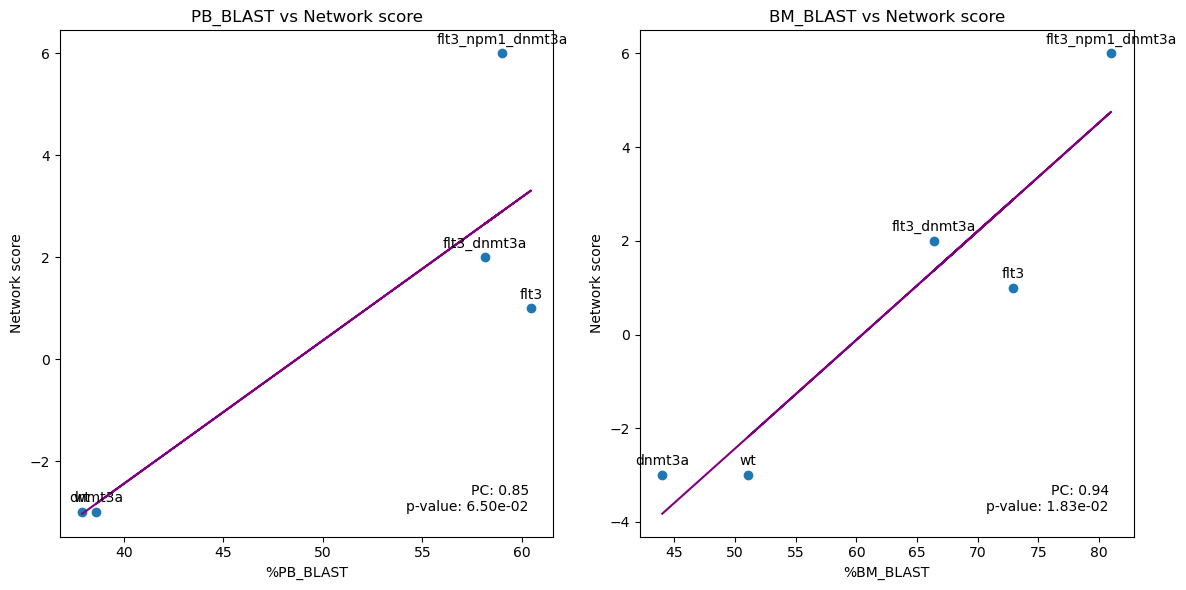

In [117]:
# The Palma results
simulation_results_1 = simulation(model1)
clinical_plot(simulation_results_1, './Data/BeatAML/clinical.csv')

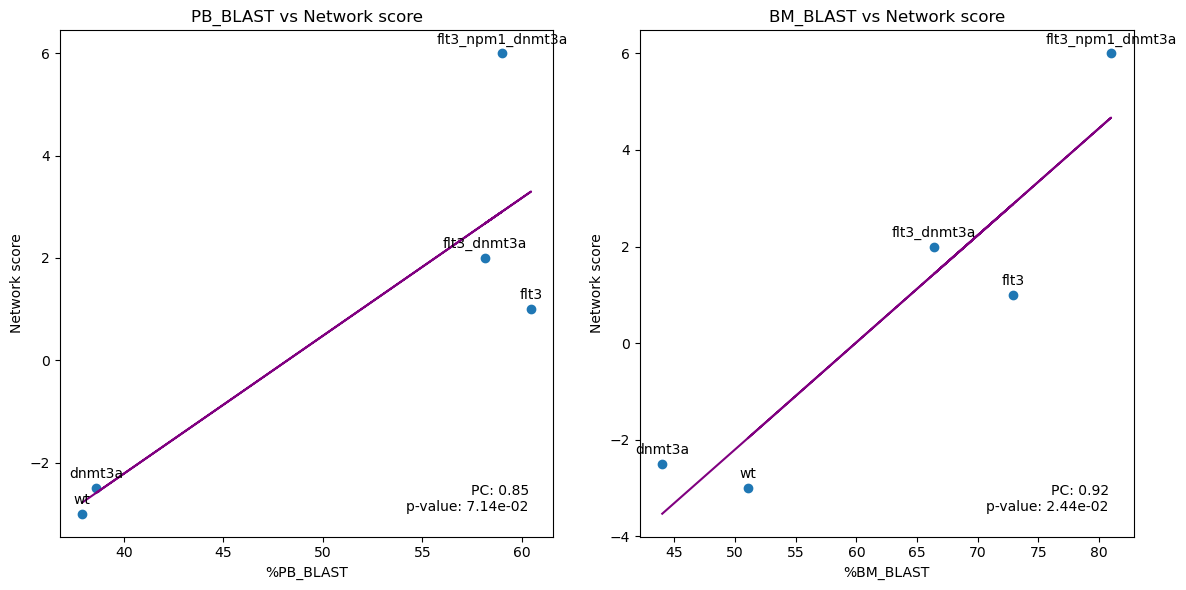

In [118]:
simulation_results_or = simulation(merged_or)
clinical_plot(simulation_results_or, './Data/BeatAML/clinical.csv')

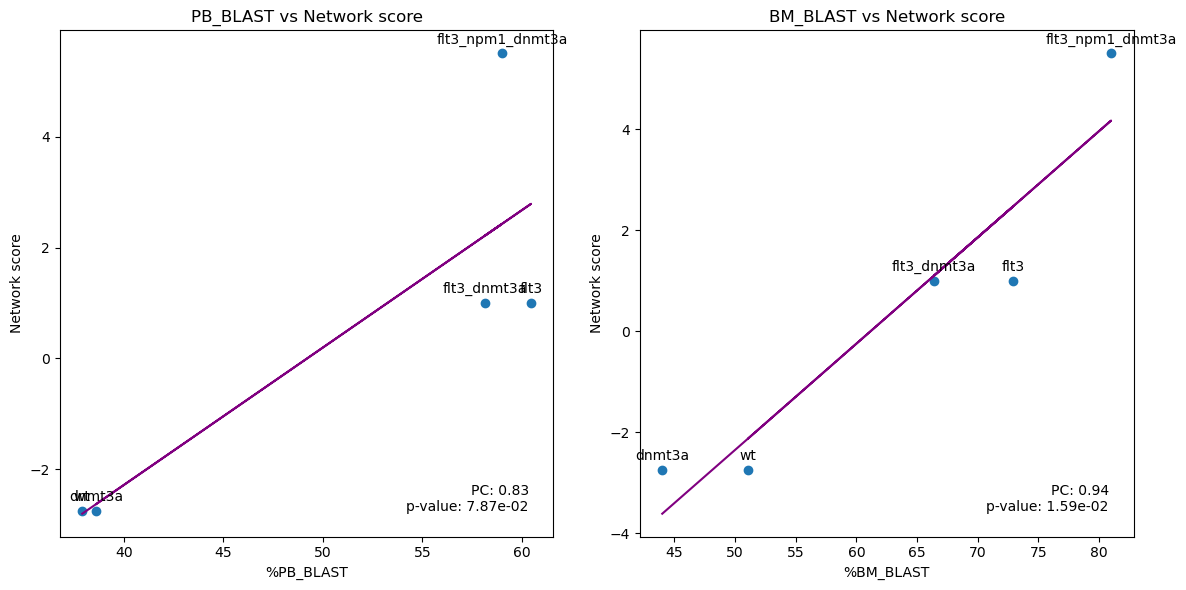

In [119]:
simulation_results_inhibitor_wins = simulation(merged_inhibitor_wins)
clinical_plot(simulation_results_inhibitor_wins, './Data/BeatAML/clinical.csv')

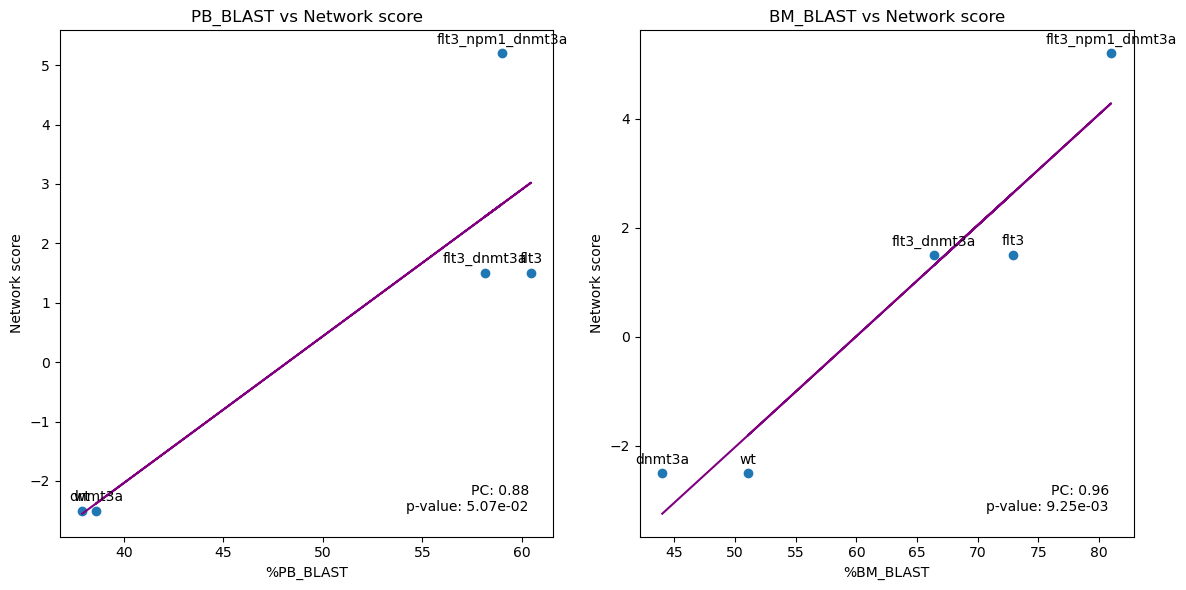

In [120]:
simulation_results_and = simulation(merged_and)
clinical_plot(simulation_results_and, './Data/BeatAML/clinical.csv')